# EM
- 混合ガウス分布から出力されたデータに対して, もとの分布のパラメータを推定する
- ガウス分布は3つ, パラメータは$\pi_k, \boldsymbol{\mu}, \boldsymbol{\Sigma}$
- Eステップではq(z)=p(z|x, θ)なので, 事後分布の計算を行う

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## データ生成
- データ数N
- クラス数K
- 次元数D
- 観測されたデータX

In [2]:
# ハイパーパラメータ
N = 300
K = 3
D = 2

# 隠れパラメータ
s1 = 0.25 / 10
s2 = 0.2 / 10

# データ生成
X1 = np.random.multivariate_normal([-0.4, 0], [[s1, s2],[s2, s1]], N//3)
X2 = np.random.multivariate_normal([ 0,   0], [[s1,-s2],[-s2,s1]], N//3)
X3 = np.random.multivariate_normal([ 0.4, 0], [[s1, s2],[s2, s1]], N//3)

# データ
X = np.random.permutation(np.concatenate([X1, X2, X3]))
print('data X shape:', X.shape)

data X shape: (300, 2)


## データの可視化

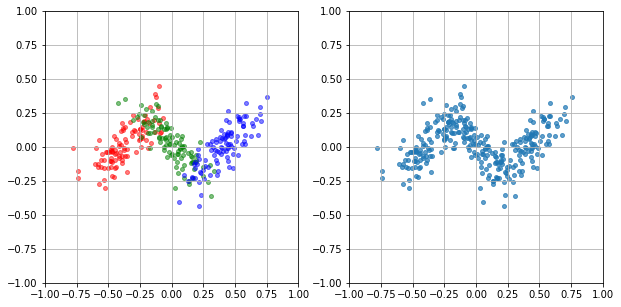

In [3]:
# データプロット
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(*X1.T, s=16, c='red', alpha=0.5)
plt.scatter(*X2.T, s=16, c='green', alpha=0.5)
plt.scatter(*X3.T, s=16, c='blue', alpha=0.5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(*X.T, s=16, alpha=0.7)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()
plt.show()

## データの初期化
- piはランダムに初期化, 確率の条件を満たすように正規化
- muはランダムに初期化
- Sigmaは単位行列で初期化(ランダムにすると半正定値性満たさない場合がある)

In [30]:
# 学習するパラメータの初期化
def init_parameter():
    global pi, mu, Sig
    pi = np.random.rand(K)
    pi /= pi.sum()
    mu = np.random.uniform(-1, 1, size=(K, D))
    Sig = np.array([np.eye(D) for _ in range(K)])

init_parameter()
print('π_k shape:', pi.shape)
print('μ_k shape:', mu.shape)
print('Σ_k shape:', Sig.shape)

[0.22500741 0.4612086  0.31378399]
π_k shape: (3,)
μ_k shape: (3, 2)
Σ_k shape: (3, 2, 2)


In [31]:
def get_likelihood(X, pi, mu, Sig):
    return np.log(np.array([pi[k] * stats.multivariate_normal.pdf(X, mean=mu[k], cov=Sig[k]) for k in range(K)]).sum(axis=0)).sum()
    
# 負担率
def get_responsibility(X, pi, mu, Sig):
    gamma = np.array([pi[k] * stats.multivariate_normal.pdf(X, mean=mu[k], cov=Sig[k]) for k in range(K)])
    return gamma / gamma.sum(axis=0)

_gamma = get_responsibility(X, pi, mu, Sig)
_Nk = _gamma.sum(axis=1)

lh = get_likelihood(X, pi, mu, Sig)
print('γ(z_nk) shape:', _gamma.shape)
print('N_k shape:', _Nk.shape, 'sum of Nk:', _Nk.sum())

γ(z_nk) shape: (3, 300)
N_k shape: (3,) sum of Nk: 300.0


## EMアルゴリズム本体

In [48]:
init_parameter()

for t in range(100):
    # E Step
    gamma = get_responsibility(X, pi, mu, Sig)
    Nk = gamma.sum(axis=1)
    # M Step
    pi_new = Nk / N
    mu_new = (gamma@X) / Nk[:, np.newaxis]
    s = np.zeros((K, D, D))
    for k in range(K):
        buf = 0
        for n in range(N):
            d = (X[n] - mu_new[k]).reshape(2,1)
            buf += gamma[k, n]*(d@d.T)
        buf /= Nk[k]
        s[k] = buf
    
    pi = pi_new
    mu = mu_new
    Sig = s

    lh = get_likelihood(X, pi, mu, Sig)
    print('iter:', t, 'lh', lh)

iter: 0 lh 25.376085739013224
iter: 1 lh 25.385922839079818
iter: 2 lh 25.398257976765567
iter: 3 lh 25.415194128640806
iter: 4 lh 25.43962771030629
iter: 5 lh 25.47585435667147
iter: 6 lh 25.530259089510576
iter: 7 lh 25.612233285147223
iter: 8 lh 25.735304435599176
iter: 9 lh 25.91831620811639
iter: 10 lh 26.18622546338389
iter: 11 lh 26.569742528596862
iter: 12 lh 27.10297874289447
iter: 13 lh 27.819151404314592
iter: 14 lh 28.746382220310252
iter: 15 lh 29.90688363128316
iter: 16 lh 31.32072980667943
iter: 17 lh 33.01096811949962
iter: 18 lh 35.00370692664188
iter: 19 lh 37.3145880842062
iter: 20 lh 39.91203041706764
iter: 21 lh 42.66391555841543
iter: 22 lh 45.324138383527554
iter: 23 lh 47.63571163152939
iter: 24 lh 49.491506249362146
iter: 25 lh 50.96131020754484
iter: 26 lh 52.2106143145773
iter: 27 lh 53.546252998873555
iter: 28 lh 55.852273424083606
iter: 29 lh 61.90174397256834
iter: 30 lh 74.22496709816696
iter: 31 lh 87.2945264913105
iter: 32 lh 96.54758347056861
iter: 33 

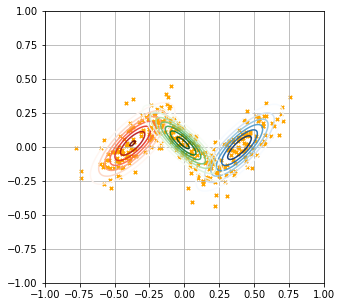

In [49]:
xx, yy = np.meshgrid(np.arange(-1, 1, 0.01),np.arange(-1, 1, 0.01))
h, w = xx.shape

plt.figure(figsize=(5,5))
grid = np.array([xx, yy]).reshape(2, -1).T
cmaps = ['Blues', 'Reds', 'Greens']
for k in range(K):
    z = stats.multivariate_normal.pdf(grid, mean=mu[k], cov=Sig[k])
    plt.contour(xx, yy, z.reshape(h, w), cmap=cmaps[k], alpha=0.9)

plt.scatter(*X.T, s=12, marker='x', c='orange')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()
plt.show()

In [50]:
print(pi)
print(mu)
print(Sig)

[0.34919449 0.33932789 0.31147762]
[[ 0.39551653 -0.00554991]
 [-0.3705148   0.02587051]
 [-0.00892962  0.02920655]]
[[[ 0.02501307  0.02060915]
  [ 0.02060915  0.02633225]]

 [[ 0.02350599  0.0178269 ]
  [ 0.0178269   0.02310836]]

 [[ 0.02119282 -0.01721616]
  [-0.01721616  0.01952004]]]
